In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import Column, Integer, String, Float

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
from dateutil.relativedelta import *

# Find last point in data to calculate 1 year ago
lastpoint = session.query(measurement.date).order_by(measurement.date.desc()).first().date
lastpoint
lastpoint=dt.datetime.strptime(lastpoint, "%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - relativedelta(months=12)
year_ago



datetime.date(2016, 8, 23)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last12 = session.query(measurement.prcp, measurement.date).filter(measurement.date >= year_ago).all()


In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(last12, columns=["prcp","date"])
prcp_df['date'] = pd.to_datetime(prcp_df['date'])
prcp_df.set_index('date', inplace=True)

# prcp_df.info()

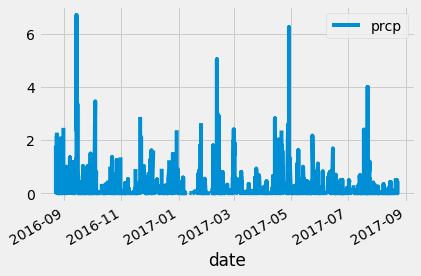

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot()
plt.savefig('Precipitation-Bar.png')

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(station.station).count()

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
topstations = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()


In [17]:
#Under the assumption I need to use the highest row count from query
topstation1 = (topstations[0])
topstation1 = (topstation1[0])

# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(measurement.tobs),func.avg(measurement.tobs),func.max(measurement.tobs),func.count(measurement.tobs)).filter(measurement.station == topstation1).all()

[(54.0, 71.66378066378067, 85.0, 2772)]

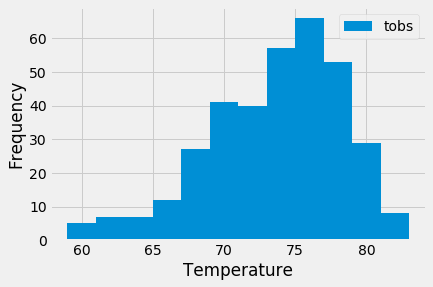

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last12station = session.query(measurement.tobs).filter(measurement.station == topstation1).filter(measurement.date >= year_ago).all()

stationdf = pd.DataFrame(last12station, columns = ["tobs"])

stationdf.plot.hist(bins = 12)
plt.xlabel('Temperature')
plt.savefig('Histogram-Temp-Bonus.png')

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
2
temp

[(62.0, 71.23529411764706, 82.0)]

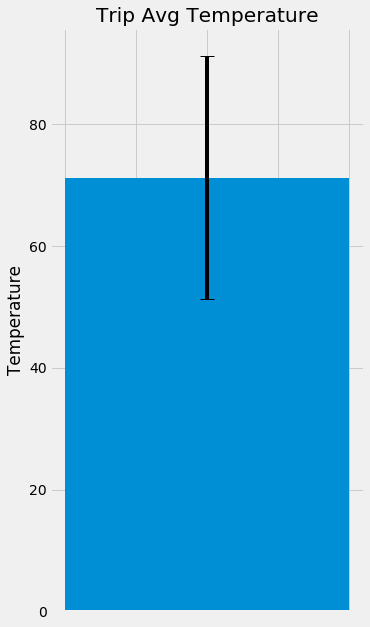

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min = 62.0
avg = 71.23
max = 82.0
error = max - min
plt.figure(figsize=[5,10]);
plt.bar(1, avg, yerr=error, align='center', 
        ecolor='black', capsize=7)
plt.ylabel('Temperature')
plt.title('Trip Avg Temperature')
plt.tick_params(labelbottom=False)
plt.savefig("BONUS-Trip Temp Avg.png")



In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(station.station, station.name, func.sum(measurement.prcp)).filter(station.station == measurement.station).\
filter(measurement.date >= '2016-08-23').filter(measurement.date <= '2016-08-30').group_by(measurement.station).\
order_by(measurement.prcp.desc()).all()


[('USC00519281', 'WAIHEE 837.5, HI US', 5.079999999999999),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 5.28),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2.9),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2.55),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 1.5899999999999999),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.17),
 ('USC00517948', 'PEARL CITY, HI US', 0.06)]

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    


In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

#vacation dates
start = '2016-08-23'
end = '2016-08-30'


startstrip = dt.datetime.strptime(start, '%Y-%m-%d')
endstrip = dt.datetime.strptime(end, '%Y-%m-%d')

dates = []
normals = []


while (startstrip <= endstrip):
    dates.append(startstrip)
    string = dt.datetime.strftime(startstrip, '%m-%d')
    normals.append(list(np.ravel(daily_normals(string))))
    startstrip = startstrip + dt.timedelta(days=1)
normals

[[67.0, 76.6923076923077, 87.0],
 [70.0, 75.96153846153847, 84.0],
 [69.0, 76.96078431372548, 82.0],
 [71.0, 76.56862745098039, 84.0],
 [68.0, 76.28301886792453, 84.0],
 [67.0, 76.73469387755102, 86.0],
 [70.0, 76.23529411764706, 85.0],
 [68.0, 76.41666666666667, 84.0]]

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normaltemp = pd.DataFrame(normals, columns = ['Min', 'Avg', 'Max'])
normaltemp['date'] = dates
normaltemp = normaltemp.set_index('date')

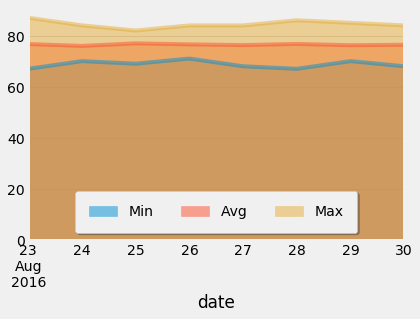

<Figure size 1080x720 with 0 Axes>

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
# Your x and y axis
ax = normaltemp.plot.area(stacked=False)
ax.legend(frameon=True, loc='lower center', ncol=3, shadow=True, borderpad=1)
plt.figure(figsize=(15,10))
plt.savefig('StackedChart-Bonus.png')

## 